## 시각화

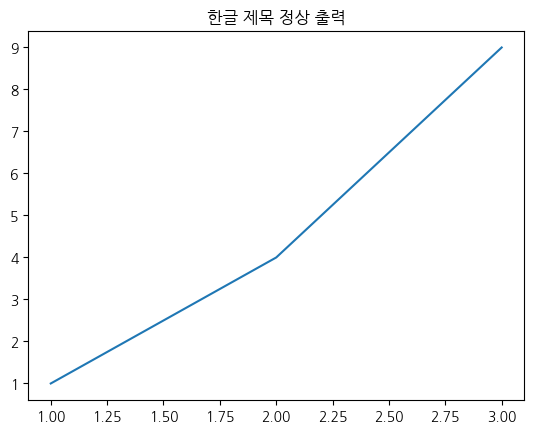

In [1]:
# 1. 나눔고딕 설치
!apt-get -qq install fonts-nanum

# 2. 런타임에 설치된 폰트 캐시 지우기
!rm -rf ~/.cache/matplotlib

# 3. 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)
plt.rc('font', family=fontprop.get_name())
plt.rc('axes', unicode_minus=False)

# ✅ 테스트
plt.plot([1,2,3], [1,4,9])
plt.title("한글 제목 정상 출력")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_store_dashboard(df, store_id):
    # --- 선택한 가맹점 및 상권 정보 ---
    store_df = df[df['가맹점구분번호'] == store_id]
    if store_df.empty:
        raise ValueError(f"Store ID {store_id} not found in dataframe.")
    store_row = store_df.iloc[0]
    region = store_row['상권']
    region_df = df[df['상권'] == region]

    # ============================================================
    # 1️⃣ KPI 카드형 시각화
    # ============================================================
    metrics = {
        '매출금액 비율': store_row.get('동일 업종 매출금액 비율', np.nan),
        '매출건수 비율': store_row.get('동일 업종 매출건수 비율', np.nan),
        '해지 가맹점 비중': store_row.get('동일 업종 내 해지 가맹점 비중', np.nan),
        '객단가 구간': store_row.get('객단가 구간', np.nan)
    }

    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    axes = axes.flatten()

    for ax, (title, val) in zip(axes, metrics.items()):
        if pd.isna(val):
            ax.text(0.5, 0.5, '데이터 없음', ha='center', va='center', transform=ax.transAxes)
            ax.set_axis_off()
            continue
        ax.set_xlim(0, 150)
        ax.barh([0], [val], color='steelblue', alpha=0.8)
        ax.axvline(100, color='gray', linestyle='--', alpha=0.6)
        ax.text(val + 2, 0, f"{val:.1f}", va='center', fontsize=12)
        ax.set_title(title)
        ax.set_yticks([])
        ax.set_xticks([0, 50, 100, 150])
    fig.suptitle(f"[{region}] 가맹점 {store_id} 주요 지표 요약", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # ============================================================
    # 2️⃣ 상권 평균 대비 Bar Chart 비교
    # ============================================================
    compare_cols = ['동일 업종 매출금액 비율', '동일 업종 매출건수 비율',
                    '동일 업종 내 해지 가맹점 비중', '동일 상권 내 해지 가맹점 비중']

    # NaN이 모두인 경우 스킵
    if store_row[compare_cols].notna().any() and region_df[compare_cols].notna().any().any():
        compare_df = pd.DataFrame({
            '지표': compare_cols,
            '가맹점': [store_row.get(c, np.nan) for c in compare_cols],
            '상권평균': [region_df[c].mean() if not region_df[c].isna().all() else np.nan for c in compare_cols]
        }).dropna()

        if not compare_df.empty:
            compare_df_melted = compare_df.melt(id_vars='지표', var_name='구분', value_name='값')
            plt.figure(figsize=(8, 5))
            sns.barplot(data=compare_df_melted, x='지표', y='값', hue='구분', palette='Set2')
            plt.axhline(100, color='gray', linestyle='--')
            plt.title(f"가맹점 {store_id} vs 상권 평균 비교", fontsize=13)
            plt.xticks(rotation=20)
            plt.tight_layout()
            plt.show()

    # ============================================================
    # 3️⃣ Radar Chart (상세 비교)
    # ============================================================
    group1 = ['배달매출금액 비율', '동일 업종 매출금액 비율', '동일 업종 매출건수 비율',
              '동일 업종 내 매출 순위 비율', '동일 상권 내 매출 순위 비율',
              '동일 업종 내 해지 가맹점 비중', '동일 상권 내 해지 가맹점 비중']

    group2 = ['가맹점 운영개월수 구간', '매출금액 구간', '매출건수 구간',
              '유니크 고객 수 구간', '객단가 구간', '취소율 구간']

    group3 = ['남성 20대이하 고객 비중', '남성 30대 고객 비중', '남성 40대 고객 비중',
              '남성 50대 고객 비중', '남성 60대이상 고객 비중', '여성 20대이하 고객 비중',
              '여성 30대 고객 비중', '여성 40대 고객 비중', '여성 50대 고객 비중',
              '여성 60대이상 고객 비중', '재방문 고객 비중', '신규 고객 비중',
              '거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율']

    groups = [group1, group2, group3]
    titles = ['평균=100 기준 지표', '1~6 구간 지표', '고객 비중 지표']
    subtexts = ['(% / 업종평균=100)', '(1 좋음, 6 나쁨)', '(% 비중)']

    short_labels = {c: c for c in group1 + group2 + group3}  # 필요시 기존 short_labels 그대로 사용 가능

    def plot_single_radar(ax, cols, title, subtext):
        valid_cols = [c for c in cols if pd.notna(store_row.get(c, np.nan)) and pd.notna(region_df[c].mean())]
        if len(valid_cols) == 0:
            ax.text(0.5, 0.5, '데이터 없음', ha='center', va='center', transform=ax.transAxes)
            ax.set_axis_off()
            return

        store_vals = store_row[valid_cols].astype(float).values
        mean_vals = region_df[valid_cols].mean().astype(float).values

        if '1~6' in title:
            store_vals = 7 - store_vals
            mean_vals = 7 - mean_vals

        angles = np.linspace(0, 2*np.pi, len(valid_cols), endpoint=False).tolist()
        store_vals = np.concatenate((store_vals, [store_vals[0]]))
        mean_vals = np.concatenate((mean_vals, [mean_vals[0]]))
        angles += angles[:1]

        ax.plot(angles, mean_vals, color='gray', linewidth=2, label=f'{region} 평균')
        ax.fill(angles, mean_vals, color='gray', alpha=0.25)
        ax.plot(angles, store_vals, color='steelblue', linewidth=2, label=f'가맹점 {store_id}')
        ax.fill(angles, store_vals, color='steelblue', alpha=0.3)

        labels = [short_labels.get(c, c) for c in valid_cols]
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, fontsize=9)
        ax.set_yticks([])
        ax.set_title(title, size=13, pad=18)
        ax.text(0.5, -0.2, subtext, transform=ax.transAxes, fontsize=10, ha='center', color='dimgray')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(polar=True))
    for ax, cols, title, subtext in zip(axes, groups, titles, subtexts):
        plot_single_radar(ax, cols, title, subtext)
    plt.suptitle(f"상권 '{region}' 내 가맹점번호 {store_id} Radar 비교", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

    # ============================================================
    # 4️⃣ 고객 구성·매출 구성 파이차트
    # ============================================================
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # 색상 팔레트 준비
    gender_palette = sns.color_palette("pastel")  # 성별·연령대
    sale_palette = sns.color_palette("Set2")      # 매출 구성
    purpose_palette = sns.color_palette("cool")   # 이용 목적

    # (1) 성별·연령대별 비중
    gender_age_cols = [c for c in store_row.index if '고객 비중' in c]
    gender_age_vals = store_row[gender_age_cols].fillna(0).astype(float)
    if gender_age_vals.sum() > 0:
        axes[0].pie(
            gender_age_vals,
            labels=gender_age_cols,
            autopct='%1.1f%%',
            startangle=90,
            colors=gender_palette[:len(gender_age_vals)]
        )
        axes[0].set_title("고객 구성 비율 (성별·연령대별)", fontsize=12)
    else:
        axes[0].text(0.5, 0.5, '데이터 없음', ha='center', va='center')
        axes[0].set_axis_off()

    # (2) 매출 구성 비율
    sale_cols = [c for c in store_row.index if '매출금액 비율' in c]
    sale_vals = store_row[sale_cols].fillna(0).astype(float)
    if sale_vals.sum() > 0:
        axes[1].pie(
            sale_vals,
            labels=sale_cols,
            autopct='%1.1f%%',
            startangle=90,
            colors=sale_palette[:len(sale_vals)]
        )
        axes[1].set_title("매출 구성 비율 (배달/방문 등)", fontsize=12)
    else:
        axes[1].text(0.5, 0.5, '데이터 없음', ha='center', va='center')
        axes[1].set_axis_off()

    # (3) 이용 목적 비율
    purpose_cols = ['거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율']
    purpose_vals = store_row[purpose_cols].fillna(0).astype(float)
    if purpose_vals.sum() > 0:
        axes[2].pie(
            purpose_vals,
            labels=purpose_cols,
            autopct='%1.1f%%',
            startangle=90,
            colors=purpose_palette[:len(purpose_vals)]
        )
        axes[2].set_title("이용 목적 구성 비율", fontsize=12)
    else:
        axes[2].text(0.5, 0.5, '데이터 없음', ha='center', va='center')
        axes[2].set_axis_off()

    plt.suptitle(f"가맹점 {store_id} 고객 및 매출 구성 비율", fontsize=14)
    plt.tight_layout()
    plt.show()



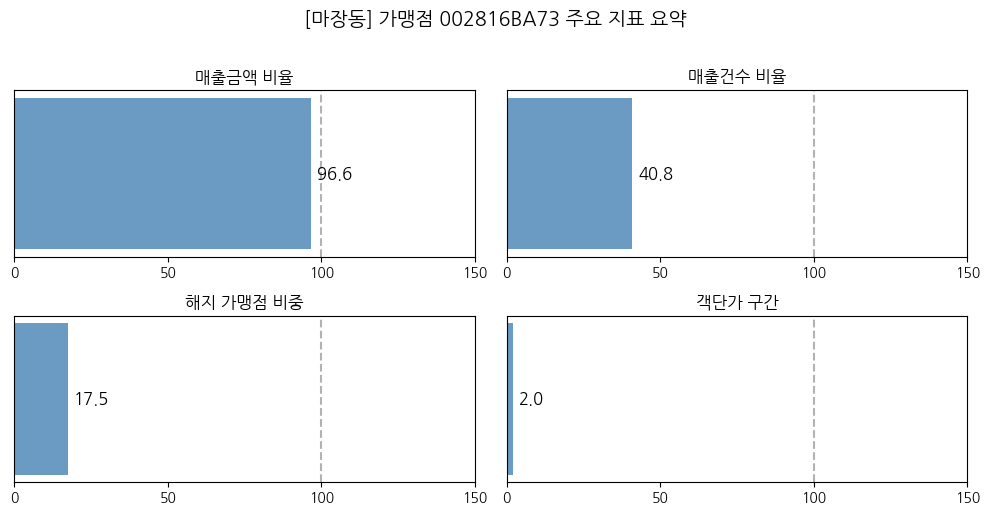

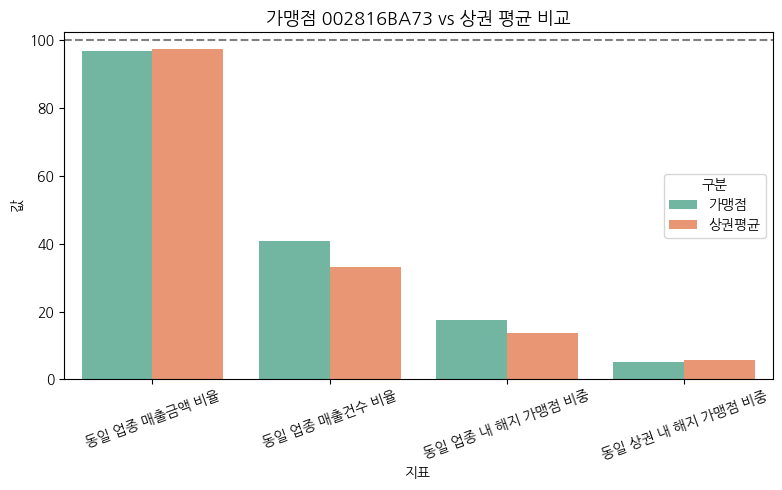

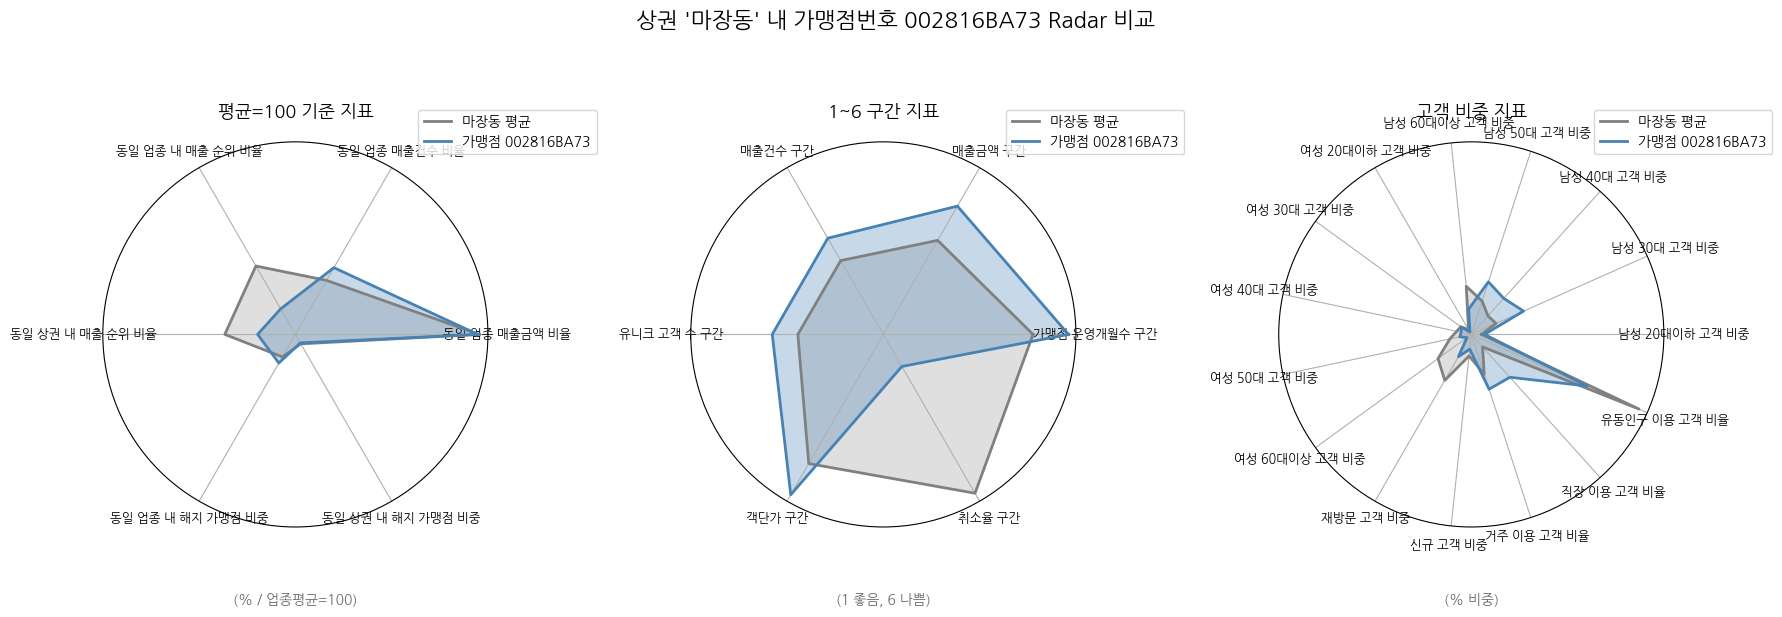

/tmp/ipython-input-148826536.py:149: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gender_age_vals = store_row[gender_age_cols].fillna(0).astype(float)
/tmp/ipython-input-148826536.py:165: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sale_vals = store_row[sale_cols].fillna(0).astype(float)
/tmp/ipython-input-148826536.py:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('futur

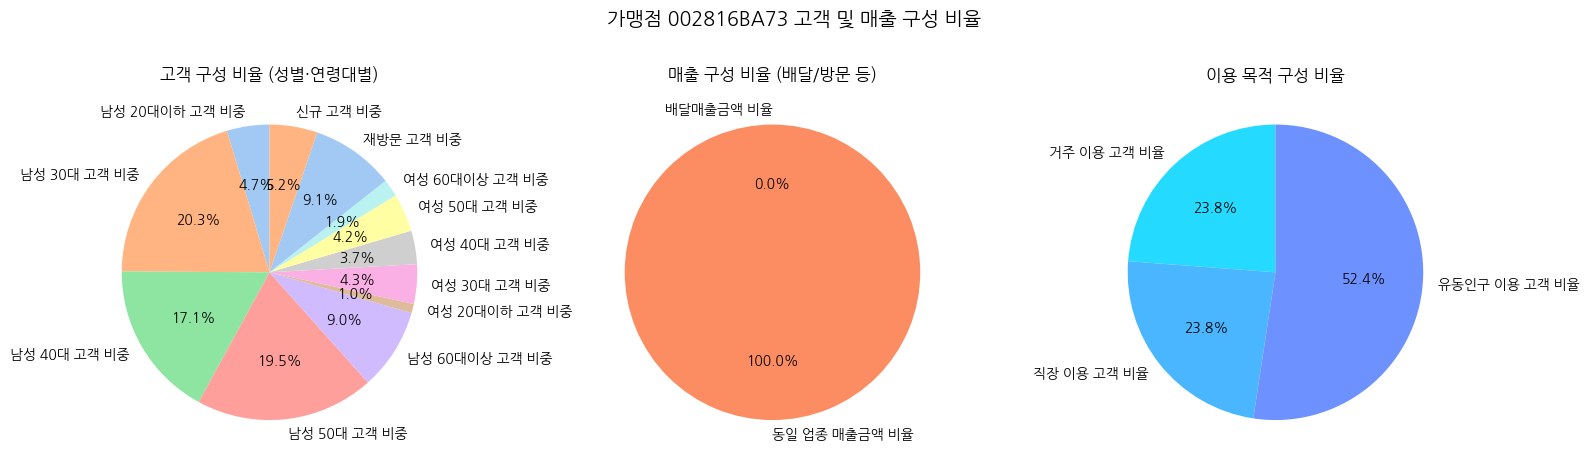

In [22]:
df = pd.read_csv('통합_제공데이터.csv')
plot_store_dashboard(df, '002816BA73')

## 최종 상권분석

In [7]:
import pandas as pd
import numpy as np
import json

def analyze_district_full(df_final, df_flow, df_rent, target_district, pretty_json=True):
    """
    상권별 전반적 분석 (매출, 유동인구, 임대료)
    JSON 형태로 결과 반환
    """
    if target_district not in df_final['상권'].unique():
        return {"에러": f"{target_district} 상권 데이터가 없습니다."}

    # ===============================
    # 1️⃣ 기본 변수 설정 및 전처리
    # ===============================
    mean100_cols = [
        '동일 업종 매출금액 비율','배달매출금액 비율','동일 업종 매출건수 비율',
        '동일 업종 내 매출 순위 비율','동일 상권 내 매출 순위 비율',
        '동일 업종 내 해지 가맹점 비중','동일 상권 내 해지 가맹점 비중'
    ]
    interval_cols = [
        '가맹점 운영개월수 구간','매출금액 구간','매출건수 구간',
        '유니크 고객 수 구간','객단가 구간','취소율 구간'
    ]
    percent_cols = [
        '남성 20대이하 고객 비중','남성 30대 고객 비중','남성 40대 고객 비중',
        '남성 50대 고객 비중','남성 60대이상 고객 비중',
        '여성 20대이하 고객 비중','여성 30대 고객 비중','여성 40대 고객 비중',
        '여성 50대 고객 비중','여성 60대이상 고객 비중',
        '재방문 고객 비중','신규 고객 비중',
        '거주 이용 고객 비율','직장 이용 고객 비율','유동인구 이용 고객 비율'
    ]
    all_cols = mean100_cols + interval_cols + percent_cols
    rank_cols = ['동일 업종 내 매출 순위 비율','동일 상권 내 매출 순위 비율']

    df = df_final.copy()
    for col in all_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # ===============================
    # 2️⃣ 상권별 통계 비교
    # ===============================
    target_df = df[df['상권'] == target_district]
    target_mean = target_df[all_cols].mean()

    overall_stats = df.groupby('상권')[all_cols].mean()
    overall_mean = overall_stats.mean()
    overall_std = overall_stats.std()

    features = {}
    for col in all_cols:
        if col not in target_mean or pd.isna(target_mean[col]):
            continue
        diff = target_mean[col] - overall_mean[col]
        std = overall_std[col] if overall_std[col] != 0 else 1
        if col in rank_cols:
            diff = -diff  # 순위비율은 낮을수록 좋음
        z = diff / std
        if z >= 0.7:
            features[col] = f"많은 편 (+{diff:.1f})"
        elif z <= -0.7:
            features[col] = f"적은 편 ({diff:.1f})"
        else:
            features[col] = "평균 수준"

    rep_upjong = target_df['업종'].value_counts().idxmax()

    # ===============================
    # 3️⃣ 유동인구 분석
    # ===============================
    df_flow_copy = df_flow.copy()
    flow_mean = df_flow_copy.groupby("상권").mean(numeric_only=True)
    if target_district not in flow_mean.index:
        flow_summary = {"유동인구 데이터": "없음"}
    else:
        flow_target = flow_mean.loc[target_district]
        flow_overall = flow_mean.mean()
        flow_std = flow_mean.std()

        time_top3 = (
            df_flow_copy[df_flow_copy["상권"] == target_district]
            .groupby("시간대구분")["총생활인구수"].mean()
            .sort_values(ascending=False)
            .head(3)
        )

        male_cols = [c for c in df_flow_copy.columns if "남자" in c and "생활인구수" in c]
        female_cols = [c for c in df_flow_copy.columns if "여자" in c and "생활인구수" in c]
        male_sum = flow_target[male_cols].sum()
        female_sum = flow_target[female_cols].sum()
        total = male_sum + female_sum
        male_ratio = male_sum / total * 100
        female_ratio = female_sum / total * 100

        age_cols = [c for c in df_flow_copy.columns if "생활인구수" in c and ("남자" in c or "여자" in c)]
        age_means = flow_target[age_cols]
        age_top3 = age_means.sort_values(ascending=False).head(3)

        flow_features = []
        for col in age_cols:
            diff = flow_target[col] - flow_overall[col]
            std = flow_std[col] if flow_std[col] != 0 else 1
            z = diff / std
            if z >= 1:
                flow_features.append(f"{col} 비중 높음 (+{diff:.1f})")
            elif z <= -1:
                flow_features.append(f"{col} 비중 낮음 ({diff:.1f})")

        flow_summary = {
            "시간대 Top3": list(time_top3.index),
            "남녀비율": {"남성": f"{male_ratio:.1f}%", "여성": f"{female_ratio:.1f}%"},
            "연령대 Top3": list(age_top3.index),
            "두드러진 특징": flow_features[:5]
        }

    # ===============================
    # 4️⃣ 임대료 비교
    # ===============================
    rent_summary = {}
    if target_district in df_rent['상권'].unique():
        target_rent = df_rent.loc[df_rent['상권'] == target_district, '임대료'].mean()
        overall_rent = df_rent['임대료'].mean()
        diff = target_rent - overall_rent
        rent_summary = {
            "해당 상권 평균 임대료": f"{target_rent:,.0f}원",
            "전체 평균 임대료": f"{overall_rent:,.0f}원",
            "비교 결과": (
                "높은 편" if diff > overall_rent * 0.3 else
                "낮은 편" if diff < -overall_rent * 0.3 else
                "평균 수준"
            )
        }
    else:
        rent_summary = {"임대료 데이터": "없음"}

    # ===============================
    # 5️⃣ 결과 JSON 생성
    # ===============================
    result = {
        "상권명": target_district,
        "대표 업종": rep_upjong,
        "주요 지표 비교": features,
        "유동인구 분석": flow_summary,
        "임대료 수준(단위: 3.3㎡당 월환산임대료)": rent_summary
    }

    # 보기 좋게 출력
    if pretty_json:
        print(json.dumps(result, ensure_ascii=False, indent=4))
    return result


In [8]:
df = pd.read_csv('통합_제공데이터.csv')
df_pop = pd.read_csv('유동인구.csv')
df_rent = pd.read_csv('임대료.csv')

analyze_district_full(df, df_pop, df_rent, '한양대')

{
    "상권명": "한양대",
    "대표 업종": "한식-육류/고기",
    "주요 지표 비교": {
        "동일 업종 매출금액 비율": "많은 편 (+76.2)",
        "배달매출금액 비율": "평균 수준",
        "동일 업종 매출건수 비율": "많은 편 (+129.6)",
        "동일 업종 내 매출 순위 비율": "많은 편 (+13.4)",
        "동일 상권 내 매출 순위 비율": "평균 수준",
        "동일 업종 내 해지 가맹점 비중": "많은 편 (+0.8)",
        "동일 상권 내 해지 가맹점 비중": "많은 편 (+1.8)",
        "가맹점 운영개월수 구간": "적은 편 (-0.2)",
        "매출금액 구간": "적은 편 (-0.8)",
        "매출건수 구간": "적은 편 (-0.7)",
        "유니크 고객 수 구간": "적은 편 (-0.8)",
        "객단가 구간": "평균 수준",
        "취소율 구간": "많은 편 (+0.1)",
        "남성 20대이하 고객 비중": "많은 편 (+21.2)",
        "남성 30대 고객 비중": "평균 수준",
        "남성 40대 고객 비중": "적은 편 (-5.0)",
        "남성 50대 고객 비중": "적은 편 (-5.4)",
        "남성 60대이상 고객 비중": "적은 편 (-8.1)",
        "여성 20대이하 고객 비중": "많은 편 (+15.0)",
        "여성 30대 고객 비중": "평균 수준",
        "여성 40대 고객 비중": "적은 편 (-4.3)",
        "여성 50대 고객 비중": "적은 편 (-3.8)",
        "여성 60대이상 고객 비중": "적은 편 (-6.3)",
        "재방문 고객 비중": "평균 수준",
        "신규 고객 비중": "평균 수준",
   

{'상권명': '한양대',
 '대표 업종': '한식-육류/고기',
 '주요 지표 비교': {'동일 업종 매출금액 비율': '많은 편 (+76.2)',
  '배달매출금액 비율': '평균 수준',
  '동일 업종 매출건수 비율': '많은 편 (+129.6)',
  '동일 업종 내 매출 순위 비율': '많은 편 (+13.4)',
  '동일 상권 내 매출 순위 비율': '평균 수준',
  '동일 업종 내 해지 가맹점 비중': '많은 편 (+0.8)',
  '동일 상권 내 해지 가맹점 비중': '많은 편 (+1.8)',
  '가맹점 운영개월수 구간': '적은 편 (-0.2)',
  '매출금액 구간': '적은 편 (-0.8)',
  '매출건수 구간': '적은 편 (-0.7)',
  '유니크 고객 수 구간': '적은 편 (-0.8)',
  '객단가 구간': '평균 수준',
  '취소율 구간': '많은 편 (+0.1)',
  '남성 20대이하 고객 비중': '많은 편 (+21.2)',
  '남성 30대 고객 비중': '평균 수준',
  '남성 40대 고객 비중': '적은 편 (-5.0)',
  '남성 50대 고객 비중': '적은 편 (-5.4)',
  '남성 60대이상 고객 비중': '적은 편 (-8.1)',
  '여성 20대이하 고객 비중': '많은 편 (+15.0)',
  '여성 30대 고객 비중': '평균 수준',
  '여성 40대 고객 비중': '적은 편 (-4.3)',
  '여성 50대 고객 비중': '적은 편 (-3.8)',
  '여성 60대이상 고객 비중': '적은 편 (-6.3)',
  '재방문 고객 비중': '평균 수준',
  '신규 고객 비중': '평균 수준',
  '거주 이용 고객 비율': '평균 수준',
  '직장 이용 고객 비율': '평균 수준',
  '유동인구 이용 고객 비율': '평균 수준'},
 '유동인구 분석': {'시간대 Top3': [14, 13, 10],
  '남녀비율': {'남성': '49.6%', '여성': '50.4%'},
  '연령